In [1]:
import os
import cv2
import matplotlib.pyplot as plt

banana_shelf_dataset_path = 'D:\Mini_Project\Datasets\Shelf_life\Banana'

def load_images_from_subfolders(folder):
    images = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.jpg'):
                img = cv2.imread(os.path.join(root, file))
                if img is not None:
                    # Convert BGR to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
    return images

banana_images = load_images_from_subfolders(banana_shelf_dataset_path)

print("Number of Banana Images:", len(banana_images))

Number of Banana Images: 512


In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [3]:
dataset_path = "D:\Mini_Project\Datasets\Shelf_life\Banana"

images = []
labels = []

shelf_life_stages = {
    "Banana(1-5)": 0,
    "Banana(5-10)": 1,
    "Banana(10-15)": 2,
    "Banana(15-20)": 3,
    "Expired": 4
}

for shelf_life_stage, label in shelf_life_stages.items():
    folder_path = os.path.join(dataset_path, shelf_life_stage)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (100, 100))  # Resize the image as needed
        images.append(image)
        labels.append(label)


In [4]:
images = np.array(images)
labels = np.array(labels)
images = images.astype('float32') / 255.0
labels = to_categorical(labels, num_classes=len(shelf_life_stages))

In [5]:
import os
import cv2
import numpy as np
from collections import defaultdict
from random import shuffle

dataset_dir = r'D:\Mini_Project\Datasets\Shelf_life\Banana' 
augmented_dir = r'D:\Mini_Project\Datasets\Shelf_Life_Prediction\Banana'

def load_images_from_subfolders(folder, target_shape=(500, 500)):
    images = defaultdict(list)
    for label in os.listdir(folder):
        label_dir = os.path.join(folder, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, target_shape)
                images[label].append(img_resized)
    return images

def augment_images(images, num_augmentations=3):
    augmented_images = defaultdict(list)
    for label, img_list in images.items():
        for img in img_list:
            augmented_images[label].append(img)
            for _ in range(num_augmentations):
                augmented_img = img.copy()  # Create a copy to avoid modifying the original
                # Perform augmentation operations (e.g., rotation, flip, etc.) here
                augmented_images[label].append(augmented_img)
    return augmented_images

images_by_class = load_images_from_subfolders(dataset_dir)
augmented_images = augment_images(images_by_class)

train_images = defaultdict(list)
test_images = defaultdict(list)
for label, images in augmented_images.items():
    shuffle(images) 
    num_train = int(0.8 * len(images))  
    train_images[label] = images[:num_train]
    test_images[label] = images[num_train:]

def save_images(images, directory):
    for label, img_list in images.items():
        label_dir = os.path.join(directory, label)
        os.makedirs(label_dir, exist_ok=True)
        for i, img in enumerate(img_list):
            img_name = f'{label}_{i}.jpg'
            img_path = os.path.join(label_dir, img_name)
            cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

save_images(train_images, os.path.join(augmented_dir, 'Train'))
save_images(test_images, os.path.join(augmented_dir, 'Test'))

print("Data augmentation completed and images saved successfully!")


Data augmentation completed and images saved successfully!


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

train_dir = r'D:\Mini_Project\Datasets\Shelf_Life_Prediction\Banana\Train'
test_dir = r'D:\Mini_Project\Datasets\Shelf_Life_Prediction\Banana\Test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator,
          epochs=16,
          validation_data=test_generator)

loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)


Found 1637 images belonging to 5 classes.
Found 411 images belonging to 5 classes.
Epoch 1/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6413 - loss: 1.5710 - val_accuracy: 0.9124 - val_loss: 0.2305
Epoch 2/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 957ms/step - accuracy: 0.9027 - loss: 0.2420 - val_accuracy: 0.8710 - val_loss: 0.2121
Epoch 3/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 51s 966ms/step - accuracy: 0.9175 - loss: 0.1904 - val_accuracy: 0.9319 - val_loss: 0.1419
Epoch 4/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 45s 846ms/step - accuracy: 0.9228 - loss: 0.1893 - val_accuracy: 0.9027 - val_loss: 0.2657
Epoch 5/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 45s 850ms/step - accuracy: 0.9140 - loss: 0.1900 - val_accuracy: 0.9319 - val_loss: 0.1647
Epoch 6/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 850ms/step - accuracy: 0.9421 - loss: 0.1274 - val_accuracy: 0.9197 - val_loss: 0.2078
Epoch 7/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 805ms/step - accuracy: 0.9453 - loss: 0.1349 - val_accuracy: 0.9392 - val_loss: 0.1460
Epoch 8/16
52/52 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


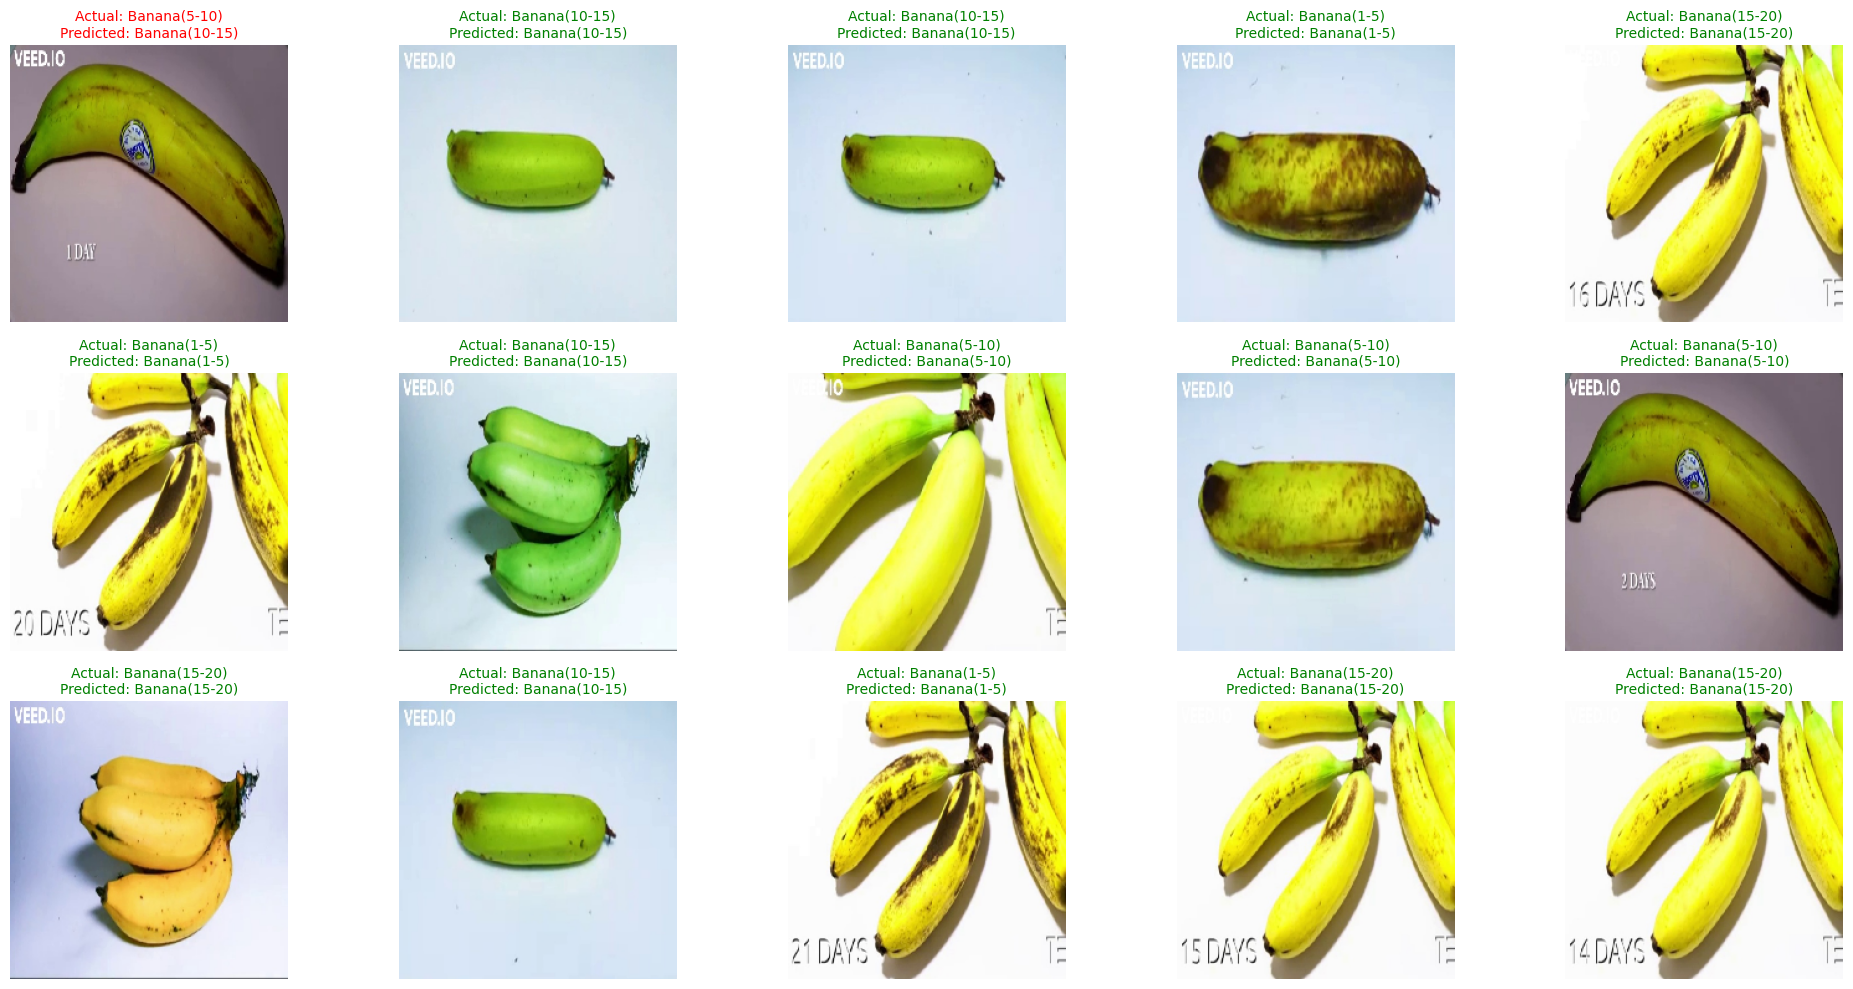

In [10]:
import numpy as np
import matplotlib.pyplot as plt

shelf_life_stages = {
    "Banana(1-5)": 0,
    "Banana(5-10)": 1,
    "Banana(10-15)": 2,
    "Banana(15-20)": 3,
    "Expired": 4
}

test_samples, test_labels = next(test_generator)
predictions = model.predict(test_samples)
predicted_labels = np.argmax(predictions, axis=1)

num_samples = min(len(test_samples), 15)
plt.figure(figsize=(20, 10))

for i in range(num_samples):
    plt.subplot(3, 5, i + 1)
    plt.imshow(test_samples[i])
    plt.axis('off')
    true_label = list(shelf_life_stages.keys())[int(np.argmax(test_labels[i]))]
    predicted_label = list(shelf_life_stages.keys())[int(predicted_labels[i])]
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f'Actual: {true_label}\nPredicted: {predicted_label}', color=color, fontsize=10)

plt.tight_layout()
plt.show()


In [12]:
from keras.models import load_model

model_path = 'D:/Mini_Project/fruit_analyzer_app/models/banana_shelf_life_model.h5'
model.save(model_path)
